## Taller (Detección)
- Realizar un modelo para la localización de objetos (Regresión de las coordenadas de los Bounding Box)

Pasos:
Crear matriz de etiquetas ( )
Graficar etiquetas en imágenes:
Las etiquetas están dadas por
dos puntos
• Inicial (x_top, y_top)
• Final (x_bottom, y_bottom)
Generar Etiquetas:
Normalizar por el tamaño de
la imagen, de esta forma el
modelo predice valores entre
0-1 por cada coordenada
[x
...
w
,
y...
h ]

2. Modelo: Extractor de características
(Convoluciones) + Cabeza (regresión de 4
variables)
3. Entrenar con función de pérdida MSE (Mean
Squared Error)
Leer el archivo en formato COCO
("bbox" : [x,y,width,height])
2. Implementar una función para
calcular el IoU de dos rectángulos
3. Determinar los rectángulos con
mayor IOU

Este notebook entrena un modelo basado en `ResNet18` para detectar la ubicación de aviones en imágenes. Utiliza coordenadas corregidas de los bounding boxes, data augmentation y entrenamiento sobre imágenes redimensionadas. Se calcula el IoU promedio como métrica de desempeño.

In [23]:
import zipfile
import os

# Ruta al archivo ZIP
zip_path = 'data/airplanes.zip'

# Ruta del directorio de destino
extract_to = 'data/airplanes'

# Crear el directorio si no existe
os.makedirs(extract_to, exist_ok=True)

# Descomprimir el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Descomprimido en: {extract_to}")

Descomprimido en: data/airplanes


In [24]:
import torch

# --- Selección dinámica del dispositivo ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando GPU NVIDIA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU Apple Silicon (MPS)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU Apple Silicon (MPS)


1. Leer el archivo de etiquetas

El archivo Airplanes.csv tiene la información de los bounding boxes (en formato COCO: [x, y, width, height]). Empezaremos leyendo ese archivo y asociándolo con las imágenes correspondientes.

In [25]:
import pandas as pd

# Leer el archivo CSV con las etiquetas
df = pd.read_csv('data/Airplanes.csv')
print(df.columns)

# Mostrar algunas filas para entender la estructura
df.head()

Index(['Unnamed: 0', 'Image', 'x_top', 'y_top', 'x_bottom', 'y_bottom',
       'label'],
      dtype='object')


,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label
0,0,image_0001.jpg,30,137,49,349,Airplanes
1,0,image_0002.jpg,35,153,59,342,Airplanes
2,0,image_0003.jpg,36,135,47,331,Airplanes
3,0,image_0004.jpg,24,141,47,342,Airplanes
4,0,image_0005.jpg,18,146,48,339,Airplanes


In [26]:
from sklearn.model_selection import train_test_split

# Partición 70% train, 30% test
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

In [27]:
df_train.head()


,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label
404,0,image_0405.jpg,32,146,54,354,Airplanes
522,0,image_0523.jpg,27,122,57,350,Airplanes
749,0,image_0750.jpg,29,129,52,352,Airplanes
426,0,image_0427.jpg,31,102,52,351,Airplanes
41,0,image_0042.jpg,31,154,52,336,Airplanes


In [28]:
df_test.head()

,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label
696,0,image_0697.jpg,31,116,56,352,Airplanes
667,0,image_0668.jpg,30,121,53,347,Airplanes
63,0,image_0064.jpg,37,140,46,342,Airplanes
533,0,image_0534.jpg,23,100,47,346,Airplanes
66,0,image_0067.jpg,25,150,44,343,Airplanes


 2. Convertir a formato COCO (x, y, width, height)

In [29]:
# Función para corregir etiquetas (coordenadas)
def corners_to_coco(x_top, y_top, x_bottom, y_bottom):
    x = x_bottom
    y = x_top
    width = y_bottom - x_bottom
    height = y_top - x_top
    return [x, y, width, height]

In [30]:
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

# Recalcular las coordenadas usando la función corregida
df_train[['x', 'y', 'width', 'height']] = df_train.apply(
    lambda row: pd.Series(corners_to_coco(row['x_top'], row['y_top'], row['x_bottom'], row['y_bottom'])),
    axis=1
)

# Coordenadas finales
df_train['x2'] = df_train['x'] + df_train['width']
df_train['y2'] = df_train['y'] + df_train['height']

# Normalizar para entrenamiento
df_train['x_norm'] = df_train['x'] / IMAGE_WIDTH
df_train['y_norm'] = df_train['y'] / IMAGE_HEIGHT
df_train['x2_norm'] = df_train['x2'] / IMAGE_WIDTH
df_train['y2_norm'] = df_train['y2'] / IMAGE_HEIGHT

# Vector para regresión
df_train['bbox_norm'] = df_train[['x_norm', 'y_norm', 'x2_norm', 'y2_norm']].values.tolist()

# Agregar ruta de imagen
df_train['image_path'] = df_train['Image'].apply(lambda x: f"data/airplanes/airplanes/{x}")
df_train.head()

,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label,x,y,width,height,x2,y2,x_norm,y_norm,x2_norm,y2_norm,bbox_norm,image_path
404,0,image_0405.jpg,32,146,54,354,Airplanes,54,32,300,114,354,146,0.105469,0.062500,0.691406,0.285156,"[0.10546875, 0.0625, 0.69140625, 0.28515625]",data/airplanes/airplanes/image_0405.jpg
522,0,image_0523.jpg,27,122,57,350,Airplanes,57,27,293,95,350,122,0.111328,0.052734,0.683594,0.238281,"[0.111328125, 0.052734375, 0.68359375, 0.23828...",data/airplanes/airplanes/image_0523.jpg
749,0,image_0750.jpg,29,129,52,352,Airplanes,52,29,300,100,352,129,0.101562,0.056641,0.687500,0.251953,"[0.1015625, 0.056640625, 0.6875, 0.251953125]",data/airplanes/airplanes/image_0750.jpg
426,0,image_0427.jpg,31,102,52,351,Airplanes,52,31,299,71,351,102,0.101562,0.060547,0.685547,0.199219,"[0.1015625, 0.060546875, 0.685546875, 0.19921875]",data/airplanes/airplanes/image_0427.jpg
41,0,image_0042.jpg,31,154,52,336,Airplanes,52,31,284,123,336,154,0.101562,0.060547,0.656250,0.300781,"[0.1015625, 0.060546875, 0.65625, 0.30078125]",data/airplanes/airplanes/image_0042.jpg


In [31]:
# Recalcular las coordenadas usando la función corregida
df_test[['x', 'y', 'width', 'height']] = df_test.apply(
    lambda row: pd.Series(corners_to_coco(row['x_top'], row['y_top'], row['x_bottom'], row['y_bottom'])),
    axis=1
)

# Coordenadas finales
df_test['x2'] = df_test['x'] + df_test['width']
df_test['y2'] = df_test['y'] + df_test['height']

# Normalizar para entrenamiento
df_test['x_norm'] = df_test['x'] / IMAGE_WIDTH
df_test['y_norm'] = df_test['y'] / IMAGE_HEIGHT
df_test['x2_norm'] = df_test['x2'] / IMAGE_WIDTH
df_test['y2_norm'] = df_test['y2'] / IMAGE_HEIGHT

# Vector para regresión
df_test['bbox_norm'] = df_test[['x_norm', 'y_norm', 'x2_norm', 'y2_norm']].values.tolist()

# Agregar ruta de imagen
df_test['image_path'] = df_test['Image'].apply(lambda x: f"data/airplanes/airplanes/{x}")
df_test.head()

,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label,x,y,width,height,x2,y2,x_norm,y_norm,x2_norm,y2_norm,bbox_norm,image_path
696,0,image_0697.jpg,31,116,56,352,Airplanes,56,31,296,85,352,116,0.109375,0.060547,0.687500,0.226562,"[0.109375, 0.060546875, 0.6875, 0.2265625]",data/airplanes/airplanes/image_0697.jpg
667,0,image_0668.jpg,30,121,53,347,Airplanes,53,30,294,91,347,121,0.103516,0.058594,0.677734,0.236328,"[0.103515625, 0.05859375, 0.677734375, 0.23632...",data/airplanes/airplanes/image_0668.jpg
63,0,image_0064.jpg,37,140,46,342,Airplanes,46,37,296,103,342,140,0.089844,0.072266,0.667969,0.273438,"[0.08984375, 0.072265625, 0.66796875, 0.2734375]",data/airplanes/airplanes/image_0064.jpg
533,0,image_0534.jpg,23,100,47,346,Airplanes,47,23,299,77,346,100,0.091797,0.044922,0.675781,0.195312,"[0.091796875, 0.044921875, 0.67578125, 0.1953125]",data/airplanes/airplanes/image_0534.jpg
66,0,image_0067.jpg,25,150,44,343,Airplanes,44,25,299,125,343,150,0.085938,0.048828,0.669922,0.292969,"[0.0859375, 0.048828125, 0.669921875, 0.29296875]",data/airplanes/airplanes/image_0067.jpg


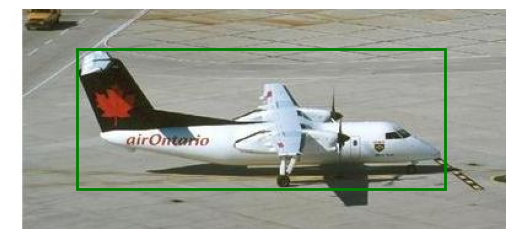

In [32]:
import matplotlib.pyplot as plt
import cv2

def show_image_with_box(image_path, x1, y1, x2, y2):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found or cannot be read: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().add_patch(
        plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='green', facecolor='none', linewidth=2)
    )
    plt.axis('off')
    plt.show()

# Mostrar la primera imagen
row = df_train.iloc[0]
show_image_with_box(row['image_path'], row['x'], row['y'], row['x2'], row['y2'])


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Esta clase personalizada de Dataset permite cargar imágenes y sus bounding boxes normalizados desde un DataFrame.
# Es compatible con DataLoader de PyTorch para entrenamiento por lotes.

class AirplaneDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  # DataFrame con rutas de imágenes y bounding boxes normalizados
        self.transform = transform  # Transformaciones de aumento y preprocesamiento

    def __len__(self):
        return len(self.dataframe)  # Número total de muestras

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')  # Carga la imagen
        bbox = torch.tensor(row['bbox_norm'], dtype=torch.float32)  # Bounding box normalizado
        if self.transform:
            image = self.transform(image)  # Aplica transformaciones si existen
        return image, bbox  # Devuelve la imagen y su bounding box

# Aumentación y normalización
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Crear dataset y dataloader train y test
dataset_train = AirplaneDataset(df_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_test = AirplaneDataset(df_test, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)


In [34]:
import torch.nn as nn
from torchvision.models import resnet18, resnet34

# Modelo con ResNet18 como backbone
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        # base = resnet18(pretrained=True)
        base = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-1])  # quitar capa final
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 4),
            nn.Sigmoid()  # Para mantener coordenadas entre 0 y 1
        )

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x)

model = ResNetBackbone().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


/opt/anaconda3/envs/computerV/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/computerV/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Calcula el IoU (Intersection over Union) entre dos cajas delimitadoras (bounding boxes)
def compute_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max((xi2 - xi1), 0) * max((yi2 - yi1), 0)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

In [37]:
# Entrenamiento
best_model = None
best_iou = 0.0
iou_per_epoch = []
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, targets in dataloader_train:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader_train)
    print(f"🔁 Epoch {epoch+1}/{EPOCHS} - Loss promedio: {avg_loss:.4f}")

🔁 Epoch 1/20 - Loss promedio: 0.0051
🔁 Epoch 2/20 - Loss promedio: 0.0037
🔁 Epoch 3/20 - Loss promedio: 0.0022
🔁 Epoch 4/20 - Loss promedio: 0.0011
🔁 Epoch 5/20 - Loss promedio: 0.0012
🔁 Epoch 6/20 - Loss promedio: 0.0013
🔁 Epoch 7/20 - Loss promedio: 0.0011
🔁 Epoch 8/20 - Loss promedio: 0.0010
🔁 Epoch 9/20 - Loss promedio: 0.0011
🔁 Epoch 10/20 - Loss promedio: 0.0012
🔁 Epoch 11/20 - Loss promedio: 0.0010
🔁 Epoch 12/20 - Loss promedio: 0.0011
🔁 Epoch 13/20 - Loss promedio: 0.0012
🔁 Epoch 14/20 - Loss promedio: 0.0011
🔁 Epoch 15/20 - Loss promedio: 0.0011
🔁 Epoch 16/20 - Loss promedio: 0.0010
🔁 Epoch 17/20 - Loss promedio: 0.0011
🔁 Epoch 18/20 - Loss promedio: 0.0015
🔁 Epoch 19/20 - Loss promedio: 0.0010
🔁 Epoch 20/20 - Loss promedio: 0.0011


In [38]:
import numpy as np
import copy
 
# Evaluar IoU en 20 muestras
model.eval()
ious = []
for i in range(20):
    image, target = dataset_test[i]
    image = image.unsqueeze(0).to(device)
    pred = model(image).detach().cpu().numpy().flatten()
    true = target.numpy().flatten()
    pred_box = [pred[0]*512, pred[1]*512, pred[2]*512, pred[3]*512]
    true_box = [true[0]*512, true[1]*512, true[2]*512, true[3]*512]
    ious.append(compute_iou(pred_box, true_box))

avg_iou = np.mean(ious)
iou_per_epoch.append(avg_iou)
print(f"🔍 IoU promedio: {avg_iou:.3f}")

if avg_iou > best_iou:
    best_model = copy.deepcopy(model.state_dict())
    best_iou = avg_iou
    print("✅ Nuevo mejor modelo guardado.")

torch.save(best_model, "mejor_modelo_bbox.pth")
print("📦 Modelo guardado.")

🔍 IoU promedio: 0.696
✅ Nuevo mejor modelo guardado.
📦 Modelo guardado.


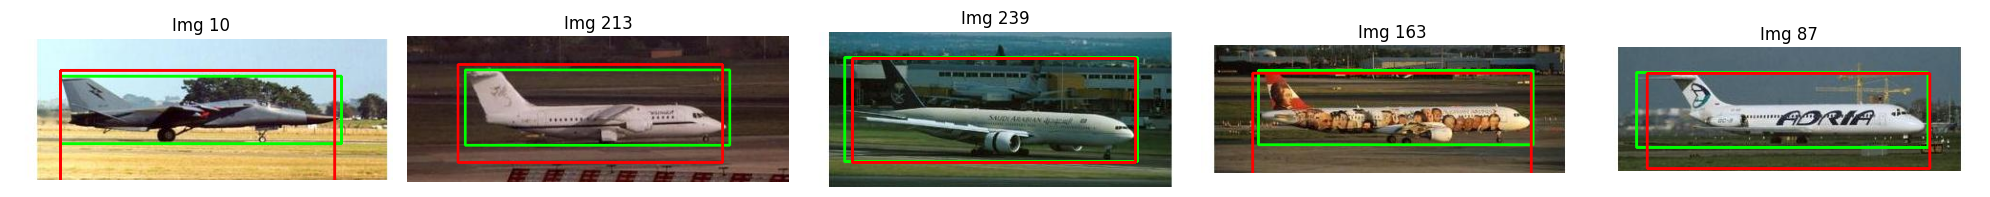

In [39]:
# box verde en la imagen: Ground Truth (bounding box real del avión)
# box rojo en la imagen: Predicción del modelo (bounding box predicha)
import matplotlib.pyplot as plt
import cv2
import random

def visualize_predictions(model, dataset, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i, idx in enumerate(indices):
        image, true_bbox = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        pred_bbox = model(image_input).detach().cpu().numpy().flatten()
        true = [int(x * 512) for x in true_bbox]
        pred = [int(x * 512) for x in pred_bbox]
        image_path = dataset.dataframe.iloc[idx]['image_path']
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img, (true[0], true[1]), (true[2], true[3]), (0, 255, 0), 2)
        cv2.rectangle(img, (pred[0], pred[1]), (pred[2], pred[3]), (255, 0, 0), 2)
        axes[i].imshow(img)
        axes[i].set_title(f'Img {idx}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, dataset_test, num_images=5)